In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
import networkx as nx
from qiskit import BasicAer
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers.nlopts.esch import ESCH
from qiskit.aqua.algorithms import QAOA
from qiskit.quantum_info import Pauli
from qiskit.aqua import Operator
import pandas as pd

In [2]:
display(HTML('<h1>Generate graph and plot it</h1>'))

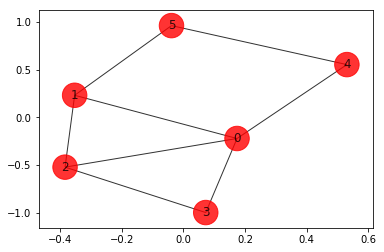

In [4]:
n = 6  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0), (1, 2, 1.0), (1, 5, 1.0), (4, 5, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
plt.show()

In [5]:
display(HTML('<h1>Generate adjacency matrix</h1>'))

In [6]:
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp['weight']

print("weigth matrix")
print(w)

weigth matrix
[[0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]]


In [7]:
display(HTML('<h1>Classical Brute Force algorithm</h1>'))

In [8]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x) + ' cost = ' + str(cost))

print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 1, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0] cost = 5.0
case = [0, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0] cost = 5.0
case = [0, 1, 1, 0, 0, 0] cost = 4.0
case = [1, 1, 1, 0, 0, 0] cost = 4.0
case = [0, 0, 0, 1, 0, 0] cost = 2.0
case = [1, 0, 0, 1, 0, 0] cost = 4.0
case = [0, 1, 0, 1, 0, 0] cost = 5.0
case = [1, 1, 0, 1, 0, 0] cost = 5.0
case = [0, 0, 1, 1, 0, 0] cost = 3.0
case = [1, 0, 1, 1, 0, 0] cost = 3.0
case = [0, 1, 1, 1, 0, 0] cost = 4.0
case = [1, 1, 1, 1, 0, 0] cost = 2.0
case = [0, 0, 0, 0, 1, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0] cost = 4.0
case = [0, 1, 0, 0, 1, 0] cost = 5.0
case = [1, 1, 0, 0, 1, 0] cost = 5.0
case = [0, 0, 1, 0, 1, 0] cost = 5.0
case = [1, 0, 1, 0, 1, 0] cost = 5.0
case = [0, 1, 1, 0, 1, 0] cost = 6.0
case = [1, 1, 1, 0, 1, 0] cost = 4.0
case = [0, 0, 0, 1, 1, 0] cost = 4.0
case = [1, 0, 0, 1, 1, 0] cost = 4.0
case = [0, 1, 0, 1, 1, 0] cost = 7.0
c

In [9]:
display(HTML('<h1>QAOA</h1>'))
display(HTML('<p>Construct cost operator</p>'))

In [12]:
num_nodes = w.shape[0]
pauli_list = []
for i in range(num_nodes):
    for j in range(i):
        if w[i, j] != 0:
            xp = np.zeros(num_nodes, dtype=np.bool)
            zp = np.zeros(num_nodes, dtype=np.bool)
            zp[i] = True
            zp[j] = True
            pauli_list.append([0.5 * w[i, j], Pauli(zp, xp)])
qubitOp = Operator(paulis=pauli_list)

In [13]:
display(HTML('<p>Run QAOA</p>'))

In [20]:
n_shots = 1024
p_steps = 1

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=n_shots)

qaoa = QAOA(qubitOp, ESCH(max_evals=100), p=p_steps, operator_mode='paulis')
result = qaoa.run(quantum_instance)
print(result)

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('solution:', max_cut.get_graph_solution(x))

{'num_optimizer_evals': 100, 'min_val': -0.67578125, 'opt_params': array([2.60969426, 0.26795845]), 'eval_time': 8.55937910079956, 'eval_count': 100, 'energy': -0.67578125, 'eigvals': array([-0.67578125]), 'min_vector': {'110110': 8, '001110': 11, '111000': 10, '111010': 22, '100000': 12, '011000': 11, '111011': 16, '001001': 12, '101000': 13, '111001': 18, '111111': 3, '000111': 16, '000011': 30, '011111': 7, '111110': 10, '100110': 19, '001000': 4, '111101': 13, '001100': 2, '110010': 7, '000010': 8, '011101': 9, '000101': 22, '010100': 17, '001010': 29, '110101': 11, '010111': 11, '011010': 57, '010001': 10, '100001': 36, '101001': 35, '000000': 5, '011110': 42, '001111': 5, '010101': 15, '000110': 12, '101011': 20, '101101': 25, '110111': 4, '010010': 15, '100111': 18, '000001': 8, '100100': 19, '110011': 3, '010000': 5, '001011': 26, '011001': 13, '011011': 19, '010110': 31, '011100': 19, '001101': 8, '000100': 11, '100011': 12, '010011': 23, '101100': 20, '111100': 15, '101010': 

In [15]:
display(HTML('<h1>Plot best assignment found</h1>'))

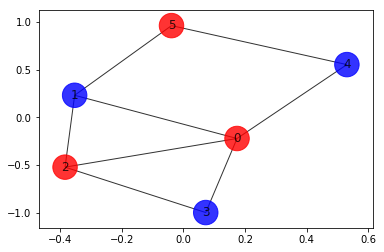

In [16]:
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
plt.show()

In [17]:
display(HTML('<h1>Plot histogram</h1>'))

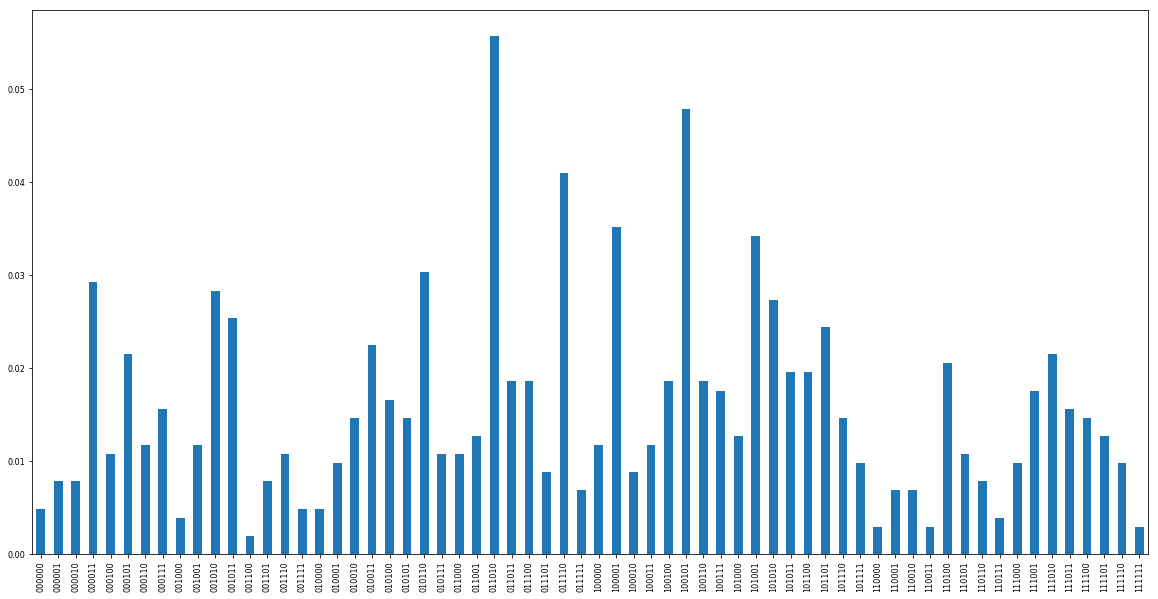

In [21]:
df = pd.DataFrame.from_dict(result['min_vector'], orient='index') / n_shots
df = df.sort_index()
barplot = df.plot.bar(legend=False, figsize=(20, 10), fontsize=8)
plt.show()